In [188]:
pip install ipymarkup

Note: you may need to restart the kernel to use updated packages.


In [189]:
from typing import List
import re
import os

import numpy as np 
import pandas as pd 
import torch
from torch import nn
from tqdm import tqdm, tqdm_notebook
from torch.optim import Adam, AdamW
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score
from ipymarkup import show_span_box_markup

pd.options.mode.chained_assignment = None  # default='warn'
import warnings

warnings.filterwarnings("ignore")

In [190]:
PATH1 = '/kaggle/input/rurebus-train-data/train_part_1/train_part_1'
PATH2 = '/kaggle/input/rurebus-train-data/train_part_2/train_part_2'
PATH3 = '/kaggle/input/rurebus-train-data/train_part_3/train_part_3'
PATH4 = '/kaggle/input/rurebus-train-data/test_ner_only'
# имена сущностей
NAMES = ['BIN', 'SOC', 'MET', 'CMP', 'ECO', 'INST', 'ACT', 'QUA']
# тэги для разметки
TAG = ['B-bin', 'I-bin', 'B-soc','I-soc','B-met', 'I-met','B-cmp','I-cmp','B-eco', 'I-eco','B-inst','I-inst','B-act','I-act','B-qua','I-qua']

Имеется 4 папки с данными: три папки с тренировочными данными (train_part_{i}) и одна с тестовыми test-ner-only.

Каждая папка с данными содержит тексты: txt файлы. Многие имена файлов оканчиваются на part_1, part_2 и тд. Если нзвания текстовых файлов отличаются лишь номером части (...part_1.txt, ...part_2.txt), то это один связный текст, разбитый на части. Каждому `.txt` файлу соответствует аннтоационный файл с таким же названием и рсширением `.ann`. Каждая строчка аннтоционного файла имеет вид:

id сущности, название именованной сущности, номер_первого_символа, номер_последнего_символа

Также в аннотациях есть строки, представляющие связи. В них указаны номера сузностей и тип связи между сущностями.

In [191]:
def make_data(path: str, filenames: List[str]) -> pd.DataFrame:
    """
    Creates dataframe with word sequences and corresponding IOB tags

    args:
        path: path to dir with .txt and .ann files
        filenames: list of filenames without extensions from `path` directory
            that will be used to create a dataset. Usually it's a list of all
            unique filenames without extensions, but it may be a subset
    returns:
        dataframe with two columns
            First column: a sequence of words.
            Second column: sequence of IOB tags
    """
    res_df = pd.DataFrame(columns = ['word', 'tag'])
    for filename in tqdm(filenames):
        df1 = make_ann(filename, path)
        df2 = make_text(filename,df1,path)
        res_df = pd.concat([res_df, df2], ignore_index=True)
    return res_df


# продготовка аннотаций
def make_ann(filename: str, path: str, on_bad_lines: str = "skip") -> pd.DataFrame:
    """
    Creates an annotation dataframe for {filename}.txt with columns:
        words: words sequence 
        coords: list of two numbers: first and last charracter
            indexes of named entity in {filename}.txt
        class: named entity type
        
        также есть другие столбцы, но они вроде бы не используются
    
    args:
        path: path to dir with .txt and .ann files
        filename: filename without extension
        on_bad_lines: принимает значения из {‘error’, ‘warn’, ‘skip’}
            Благодаря on_bad_lines='skip' пропустим строки исходного .ann файла,
            в которых число элементов не соотвествует количеству столбцов.
    returns: 
        annotation dataframe for {filename}.txt
    """
    filepath = os.path.join(path, f"{filename}.ann")

    ann_df = pd.read_csv(filepath, sep='\t', engine='python',
                         header=None, on_bad_lines=on_bad_lines)
    # Дадим столбцам названия.
    ann_df.rename(columns = {1:'class_and_coords', 2:'words'}, inplace = True )
    # Разделим в разные столбцы классы и координаты.
    # ann_df.insert(2, 'coords' , ann_df['class'])  # Я не понял, зачем это нужно
    ann_df['class'] = ann_df['class_and_coords'].apply(lambda x: x.split(" ")[0])
    ann_df['coords'] = ann_df['class_and_coords'].apply(lambda x: x.split(" ")[1:])
    ann_df = ann_df.drop('class_and_coords', axis = 1)

    # Удалим строки с аннтоациями отношений
    ann_df = ann_df.dropna()
    ann_df.reset_index(drop= True , inplace= True )

    # Чистка текстовых данных?
    ann_df['words'] = ann_df['words'].apply(lambda x: my_split(x.split(" ")))
    ann_df['words'] = ann_df['words'].apply(lambda x: del_all(x))
    ann_df['words'] = ann_df['words'].apply(lambda x: [item.strip() for item in x if item not in ['','»', '«',':',' ']])

    # coords 1 нужен для сортировки
    ann_df.insert(2, 'coords1' , ann_df['coords'])
    ann_df['coords1'] = ann_df['coords1'].apply(lambda x: int(x[0]))
    ann_df = ann_df.sort_values(by='coords1')
    ann_df.reset_index(drop= True , inplace= True )
    return ann_df


def make_text(file, df, path):
    """
    делаем разметку данных и чистим их
    
    """
    # открываем файл и записываем его в dataframe
    with open(path+'/'+file+'.txt') as f:
        lines = f.readlines()
    text_df = pd.DataFrame({'word':lines})
    
    # считаем длины строк для удобства дальнейшей разметки
    text_df.insert(1, 'len' , text_df['word'].copy())
    text_df['len'] = text_df['len'].apply(lambda x: len(x)) # считаем длину строки
    new_lens = [text_df['len'][0]] # считаем длину предыдущих строк + длина новой строки
    for i in range(1, len(list(text_df['len']))):
        new_lens.append(sum(list(text_df['len'])[:i+1]))
    text_df.insert(2, 'new_len' , new_lens)
    
    # добавляем столбец для разметки
    text_df.insert(3, 'tag', 0)
    
    # удаляем \n
    text_df['word'] = text_df['word'].apply(lambda x: re.split('\n',x)[0])
    #удаляем строрки с []
    idx = [i for i in range(len(text_df)) if len(text_df['word'][i])==0]
    text_df = text_df.drop(index=idx)
    text_df.reset_index(drop = True, inplace= True)
    
    # делаем разметку
    # находим индекс строки для каждой аннотации
    df = find_rows(text_df, df)
    
    # преобразовываем строку в массив
    text_df['word'] = text_df['word'].apply(lambda x: my_split([item for item in re.split(' ',x) if item != '']))
    text_df['word'] = text_df['word'].apply(lambda x: del_all(x))
    text_df['word'] = text_df['word'].apply(lambda x: [item.strip() for item in x if item not in ['',' ']])
    
    # момент разметки
    text_df = make_markup(text_df, df)
    text_df = last_changes(text_df)
    
    # удаляем вспомогательные столбцы
    del text_df['len']
    del text_df['new_len']
    text_df['word'] = text_df['word'].apply(lambda x: [item.lower() for item in x if item not in ['',' ']])
    idx = [i for i in range(len(text_df)) if len(text_df['word'][i])==0]
    text_df = text_df.drop(index=idx)
    text_df.reset_index(drop = True, inplace= True)
    # удаляем оставшуюся пунктуацию
    text_df = punctuation(text_df)
    return text_df


# отделяем знаки пунктуации и другие от слов
def my_split(lst):
    for k in range(3):
        for i in range(len(lst)-1,-1,-1):
            if lst[i] in ['',' ']:
                lst.pop(i)
            else:
                lst[i] = lst[i].replace('\xa0', ' ').replace('\t', ' ').replace('…','')
                idx = []
                lens = len(lst[i])
                for item in ['+', ')', '»',';','.',',', '"','(', '«',':',' ', '-\t','\\', '/','”','“','-','–','_________','*','№','%']:
                     idx.append(lst[i].find(item))
                for item in ['\xa0','"','.']:
                    if lst[i].endswith(item) and lens-1 not in idx:
                        idx.append(lens-1)                    
                idx.sort(reverse=True)
                for item in idx:
                    if item!=-1 and item!=0:
                        lst.insert(i+1, lst[i][item])
                        lst.insert(i+2, lst[i][item+1:])
                        lst[i] = lst[i][:item]
                    elif item!=-1 and item == 0:
                        lst.insert(i+1, lst[i][item+1:])
                        lst[i] = lst[i][item]
                    elif item!= -1 and item == lens-1:
                        lst.insert(i+1, lst[i][item])
                        lst[i] = lst[i][:item] 
    return lst


def del_all(lst):
    start = lst.copy()
    for i in range(len(lst)-1,-1,-1):
        split = lst[i]
        split = split.split(' ')
        if len(split) > 1:
            for j in range(len(split)):
                lst.insert(i+1+j, split[j])
            lst.pop(i)
    return lst


def last_changes(df):
    """
    размечаем строки без сущностей и оставшиеся слова не являющиеся сущностями
    """
    for i in range(len(df)):
        if df['tag'][i] == 0:
            df['tag'][i] = ['O'] * len(df['word'][i])
        else:
            llst = []
            for item in df['tag'][i]:
                if item in TAG:
                    llst.append(item)
                else:
                    llst.append('O')
            df['tag'][i] = llst
        assert (len(df['word'][i]) == len(df['tag'][i]))
    return df


def find_rows(txt_df, ann_df):
    """
    находим индекс строки для каждой аннотации
    """
    ann_df.insert(4, 'idx' , 0)
    for i in range(len(ann_df)):
        for j in range(len(txt_df)):
            start = txt_df['new_len'][j]-txt_df['len'][j]
            end = txt_df['new_len'][j]
            if int(ann_df['coords'][i][0]) in np.arange(start, end):
                ann_df['idx'][i] = j
                break
            else:
                pass
    return ann_df
    
    
def make_markup(text_df, ann_df):
    """
    делаем BIO разметку
    """
    for i in range(len(ann_df)):
        words_count = len(ann_df['words'][i])
        lens = [len(item) for item in ann_df['words'][i]] 
        row = text_df.iloc[[ann_df['idx'][i]]]
        if row['tag'].item() == 0:
                        text_df['tag'][ann_df['idx'][i]] = text_df['word'][ann_df['idx'][i]].copy()
                        row['tag'] = row['word']
        for k in range(words_count):
                if k == 0:
                    idx = (row['tag'].item()).index(ann_df['words'][i][k])
                    text_df['tag'][ann_df['idx'][i]][idx] = 'B-'+ ann_df['class'][i].lower()
                else:
                    idx = row['tag'].item().index(ann_df['words'][i][k])
                    text_df['tag'][ann_df['idx'][i]][idx] = 'I-'+ ann_df['class'][i].lower()
    return text_df


def remove_punctuation(sentence):
    """
    вспомогательная функция для удаления пунктуационных знаков
    """
    cleaned_sentence = re.sub(r'[?!\'"#]', '', sentence)
    cleaned_sentence = re.sub(r'[-.,;:(){}\/<>№»«|-|_]', '', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace('┌───┬──────────────┬───────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────┬─','')
    cleaned_sentence = cleaned_sentence.replace('├────────┬────┬────┬────┬────┬────┬────┬────┬────┬────┬────┬────┼──────┬──────┬───────┬──────┬───────┬───────┬───────┬───────┬───────┬───────┼─','')
    return cleaned_sentence


def punctuation(df):
    """
    удаляем пунктуационные знаки
    """
    for i in range(len(df)):
        lst = df['word'][i]
        for j in range(len(lst)-1,-1,-1):
            res = remove_punctuation(lst[j])
            if res =='' or res == ' ':
                df['word'][i].pop(j)
                df['tag'][i].pop(j)
    return df

In [192]:
# Filenames without extensions
filenames = [filename[:-4] for filename in os.listdir(PATH1) if filename[-4:] == '.txt']
train_df = make_data(PATH1, filenames)

100%|██████████| 99/99 [01:34<00:00,  1.05it/s]


In [193]:
filenames =  [filename[:-4] for filename in os.listdir(PATH3) if filename[-4:] == '.txt']
train_df_2 = make_data(PATH3, filenames)
train_df = pd.concat([train_df, train_df_2], ignore_index=True)

100%|██████████| 51/51 [01:48<00:00,  2.13s/it]


In [194]:
filenames =  [filename[:-4] for filename in os.listdir(PATH2) if filename[-4:] == '.txt']
train_df_3 = make_data(PATH2, filenames)
train_df = pd.concat([train_df, train_df_3], ignore_index=True)

100%|██████████| 38/38 [01:21<00:00,  2.15s/it]


In [195]:
# файлы для валидации

# val_filenames = [filename[:-4] for filename in os.listdir(PATH2) if filename[-4:] == '.txt']
# first_val_filename = val_filenames[0]  # use only one file
# val_df = make_data( PATH2,[first_val_filename])
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df.reset_index(drop = True, inplace= True)
val_df.reset_index(drop = True, inplace= True)

In [196]:
train_df.head()

,word,tag
0,"[таблица, 3]","[O, O]"
1,"[проверка, надежности, разъемных, соединений]","[B-act, I-act, I-act, I-act]"
2,"[объёмы, финансирования, программы, за, счет, ...","[B-met, I-met, O, O, O, B-eco, I-eco, I-eco, O..."
3,"[организационные, механизмы, реализации, страт...","[B-act, I-act, I-act, I-act, O, O, O, O, O]"
4,"[риск, может, быть, связан, с, форс, мажорными...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [197]:
val_df.head()

,word,tag
0,"[таблица, 2]","[O, O]"
1,"[8, механизм, реализации, муниципальной, прогр...","[O, O, B-bin, O, O]"
2,"[перечень, мероприятий, муниципальной]","[O, O, O]"
3,"[в, связи, с, сезонным, характером, проводимых...","[O, O, O, O, O, B-bin, B-act, I-act, I-act, O,..."
4,"[характеристика, и, анализ, текущего, состояния]","[O, O, O, O, O]"


In [198]:
vocab = build_vocab_from_iterator(train_df['word'], min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])
vocab_lables = build_vocab_from_iterator(train_df['tag'], min_freq=1)

In [199]:
def make_tl(df):
    tokens = []
    lables = []
    max_len = 0
    for ind in df.index:
        tokens.append(vocab(df['word'][ind]))
        lables.append(vocab_lables(df['tag'][ind]))
        if len(df['word'][ind]) > max_len:
            max_len = len(df['word'][ind])
    df['tokens'] = tokens
    df['lables'] = lables
    return df,max_len


def make_pad(df):
    list_sent = []
    list_labels = []
    for ind in df.index:
        list_sent.append(df['tokens'][ind])
        list_labels.append(df['lables'][ind])
    padded_sent = pad_sequences(list_sent)
    padded_labels = pad_sequences(list_labels)
    print(padded_sent.shape)
    padd_df = pd.DataFrame(columns = ['sentence', 'labels'])
    padd_df['sentence'] = pd.Series(padded_sent.tolist())
    padd_df['labels'] = pd.Series(padded_labels.tolist())
    return padd_df

In [200]:
train_df,max_len1 = make_tl(train_df)
val_df,max_len2 = make_tl(val_df)
train_df

,word,tag,tokens,lables
0,"[таблица, 3]","[O, O]","[201, 23]","[0, 0]"
1,"[проверка, надежности, разъемных, соединений]","[B-act, I-act, I-act, I-act]","[2267, 1506, 18878, 8264]","[9, 1, 1, 1]"
2,"[объёмы, финансирования, программы, за, счет, ...","[B-met, I-met, O, O, O, B-eco, I-eco, I-eco, O...","[5386, 86, 4, 20, 90, 37, 55, 49, 1941, 1962, ...","[8, 3, 0, 0, 0, 5, 2, 2, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[организационные, механизмы, реализации, страт...","[B-act, I-act, I-act, I-act, O, O, O, O, O]","[1951, 1182, 7, 383, 1161, 18823, 3, 4118, 1753]","[9, 1, 1, 1, 0, 0, 0, 0, 0]"
4,"[риск, может, быть, связан, с, форс, мажорными...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1587, 258, 318, 5596, 6, 11881, 16047, 10298,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
16332,"[к, программе]","[O, O]","[12, 91]","[0, 0]"
16333,"[оборудовано, жилищного, фонда]","[B-bin, B-eco, I-eco]","[10275, 480, 538]","[4, 5, 2]"
16334,"[благоустройство, территорий]","[B-act, I-act]","[821, 173]","[9, 1]"
16335,"[заместитель, главы, кетовского, сельсовета]","[O, O, O, O]","[1693, 633, 1624, 406]","[0, 0, 0, 0]"


In [201]:
print(max_len1, ' ',max_len2)

244   154


In [202]:
# делаем паддинг 
train_df = make_pad(train_df)
val_df = make_pad(val_df)
train_df

(16337, 244)
(1816, 154)


,sentence,labels
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
16332,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
16333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
16334,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
16335,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [203]:
print(len(train_df['sentence'][4]),len(val_df['sentence'][4]))

244 154


In [204]:
def one_hot(x: np.ndarray, vocab_len: int) -> np.ndarray:
    """
    Args:
        x - одномерный массив значений словаря
        vocab_len - длина словаря
    Выход:
        двумерный массив encoded, где encoded[i] - результат one hot кодирования x[i]
    """
    encoded = np.zeros((len(x), vocab_len))
    for i in range(len(x)):
        encoded[i][x[i]] = 1
    return encoded

text_vocab_len = len(vocab)
target_vocab_len = len(vocab_lables)

class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, data, text_vocab_len = text_vocab_len, target_vocab_len = target_vocab_len, classes = None,
                 transform=None, target_transform=None):
        self.data = data
        self.sequence_len = len(data.iloc[0][0])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        tokens, tag = self.data.iloc[idx]
        return torch.Tensor(tokens).int(), torch.Tensor(one_hot(tag, target_vocab_len))
        # return torch.Tensor(tokens).int(), torch.Tensor(tag)


In [205]:
datasets = {
    'train': TokenDataset(train_df),
    'val': TokenDataset(val_df)
}

In [206]:
dataloader = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=16,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [207]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [208]:
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, n_classes, embedding_dim=250, hidden_size = 32, filters=((2, 10), (3, 8))):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=200, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool1d(2)
        input_size = 100
        self.hidden_size = hidden_size
        self.lstm_layer = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, n_classes)
        outputs = []

    def forward(self, inputs):
        projections = self.embeddings_layer.forward(inputs) 
        projections = projections.transpose(1, 2)
        projections = self.conv1(projections)
        projections = projections.transpose(1, 2)
        projections = self.pool1(projections)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        output = output.reshape(-1, self.hidden_size)
        output = self.fc(output)
        return output


In [292]:
def train_model(model, criterion, optimizer, num_epochs, dataloader,device):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    loss_list = {'train' : [], 'val':[]}
    acc_list = {'train' : [], 'val':[]}
    f1_list = {'train' : [], 'val':[]}
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=10,
                                                   gamma=0.1)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                print('start train')
                model.train()
                lr_scheduler.step(epoch)
            else:
                model.eval()

            running_loss = 0.0
            all_true_labels = []
            all_preds = []
            inputs_str = []
            for inputs, labels in tqdm(dataloader[phase]):
                batch_size, n_words, n_classes = labels.shape
                labels = labels.reshape(-1, n_classes).to(device)
                outputs = model(inputs.to(device))
                
                loss = criterion(outputs, labels)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() #* inputs.size(0)
                _, labels = torch.max(labels, 1)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())
            epoch_loss = running_loss /len(dataloader[phase])
            epoch_acc = accuracy_score(all_preds, all_true_labels)
            epoch_f1 = f1_score(all_preds, all_true_labels, average='macro')
            print('{} loss: {:.4f}, acc: {:.4f}, f1: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc,
                                                        epoch_f1            
                                                        ))
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc.tolist())
            f1_list[phase].append(epoch_f1.tolist())
    return all_true_labels, all_preds, inputs_str, loss_list, acc_list, f1_list

In [293]:
n_classes = len(vocab_lables)
model = CNN_LSTM(len(vocab), n_classes = n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr = 4e-4)

In [294]:
epox_num = 15
all_true_labels, all_preds, inputs_str, loss, acc, f1 = train_model(model, criterion, optimizer, epox_num, dataloader,device)

Epoch 1/15
----------
start train


100%|██████████| 1022/1022 [01:33<00:00, 10.94it/s]


train loss: 0.1944, acc: 0.9679, f1: 0.0662


100%|██████████| 114/114 [00:01<00:00, 58.99it/s]


val loss: 0.1607, acc: 0.9577, f1: 0.0866
Epoch 2/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.91it/s]


train loss: 0.0959, acc: 0.9731, f1: 0.1374


100%|██████████| 114/114 [00:01<00:00, 57.73it/s]


val loss: 0.1454, acc: 0.9616, f1: 0.1532
Epoch 3/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.92it/s]


train loss: 0.0815, acc: 0.9768, f1: 0.2223


100%|██████████| 114/114 [00:01<00:00, 59.10it/s]


val loss: 0.1337, acc: 0.9653, f1: 0.2382
Epoch 4/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.89it/s]


train loss: 0.0689, acc: 0.9800, f1: 0.3249


100%|██████████| 114/114 [00:01<00:00, 59.50it/s]


val loss: 0.1259, acc: 0.9677, f1: 0.3234
Epoch 5/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.89it/s]


train loss: 0.0590, acc: 0.9827, f1: 0.4126


100%|██████████| 114/114 [00:01<00:00, 58.23it/s]


val loss: 0.1217, acc: 0.9689, f1: 0.3640
Epoch 6/15
----------
start train


100%|██████████| 1022/1022 [01:42<00:00,  9.94it/s]


train loss: 0.0512, acc: 0.9848, f1: 0.4705


100%|██████████| 114/114 [00:01<00:00, 58.18it/s]


val loss: 0.1213, acc: 0.9694, f1: 0.3846
Epoch 7/15
----------
start train


100%|██████████| 1022/1022 [01:42<00:00,  9.93it/s]


train loss: 0.0452, acc: 0.9864, f1: 0.5124


100%|██████████| 114/114 [00:02<00:00, 48.46it/s]


val loss: 0.1226, acc: 0.9703, f1: 0.4029
Epoch 8/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.92it/s]


train loss: 0.0402, acc: 0.9877, f1: 0.5505


100%|██████████| 114/114 [00:01<00:00, 58.70it/s]


val loss: 0.1231, acc: 0.9703, f1: 0.4257
Epoch 9/15
----------
start train


100%|██████████| 1022/1022 [01:42<00:00,  9.93it/s]


train loss: 0.0362, acc: 0.9889, f1: 0.5927


100%|██████████| 114/114 [00:01<00:00, 58.20it/s]


val loss: 0.1246, acc: 0.9708, f1: 0.4491
Epoch 10/15
----------
start train


100%|██████████| 1022/1022 [01:42<00:00,  9.93it/s]


train loss: 0.0325, acc: 0.9900, f1: 0.6315


100%|██████████| 114/114 [00:01<00:00, 58.85it/s]


val loss: 0.1296, acc: 0.9709, f1: 0.4520
Epoch 11/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.83it/s]


train loss: 0.0273, acc: 0.9918, f1: 0.6769


100%|██████████| 114/114 [00:01<00:00, 58.55it/s]


val loss: 0.1281, acc: 0.9713, f1: 0.4656
Epoch 12/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.83it/s]


train loss: 0.0260, acc: 0.9923, f1: 0.6901


100%|██████████| 114/114 [00:01<00:00, 59.76it/s]


val loss: 0.1288, acc: 0.9713, f1: 0.4671
Epoch 13/15
----------
start train


100%|██████████| 1022/1022 [01:44<00:00,  9.77it/s]


train loss: 0.0252, acc: 0.9926, f1: 0.6990


100%|██████████| 114/114 [00:01<00:00, 59.17it/s]


val loss: 0.1299, acc: 0.9714, f1: 0.4661
Epoch 14/15
----------
start train


100%|██████████| 1022/1022 [01:43<00:00,  9.89it/s]


train loss: 0.0246, acc: 0.9928, f1: 0.7056


100%|██████████| 114/114 [00:01<00:00, 57.68it/s]


val loss: 0.1295, acc: 0.9713, f1: 0.4742
Epoch 15/15
----------
start train


100%|██████████| 1022/1022 [01:44<00:00,  9.79it/s]


train loss: 0.0240, acc: 0.9930, f1: 0.7115


100%|██████████| 114/114 [00:01<00:00, 59.11it/s]


val loss: 0.1307, acc: 0.9713, f1: 0.4735


In [337]:

def graf(loss, acc):
    epox_list = [i for i in range(epox_num)]
    fig, ax = plt.subplots(2, 3, figsize=(26, 13))
    ax[0, 0].plot(epox_list, loss['train'])
    ax[0, 0].set_title("Изменение потерь на обучающей выборке")
    ax[0, 1].plot(epox_list, acc['train'])
    ax[0, 1].set_title("Изменение точности на обучающей выборке")
    ax[0, 2].plot(epox_list, f1['train'])
    ax[0, 2].set_title("Изменение f1-score на обучающей выборке")
    ax[1, 0].plot(epox_list, loss['val'])
    ax[1, 0].set_title("Изменение потерь на валидационной выборке")
    ax[1, 1].plot(epox_list, acc['val'])
    ax[1, 1].set_title("Изменение точности на валидационной выборке")
    ax[1, 2].plot(epox_list, f1['val'])
    ax[1, 2].set_title("Изменение f1-score на валидационной выборке")
    plt.savefig('res.png')
    plt.show()

In [336]:
plt.savefig('res.png')

<Figure size 640x480 with 0 Axes>

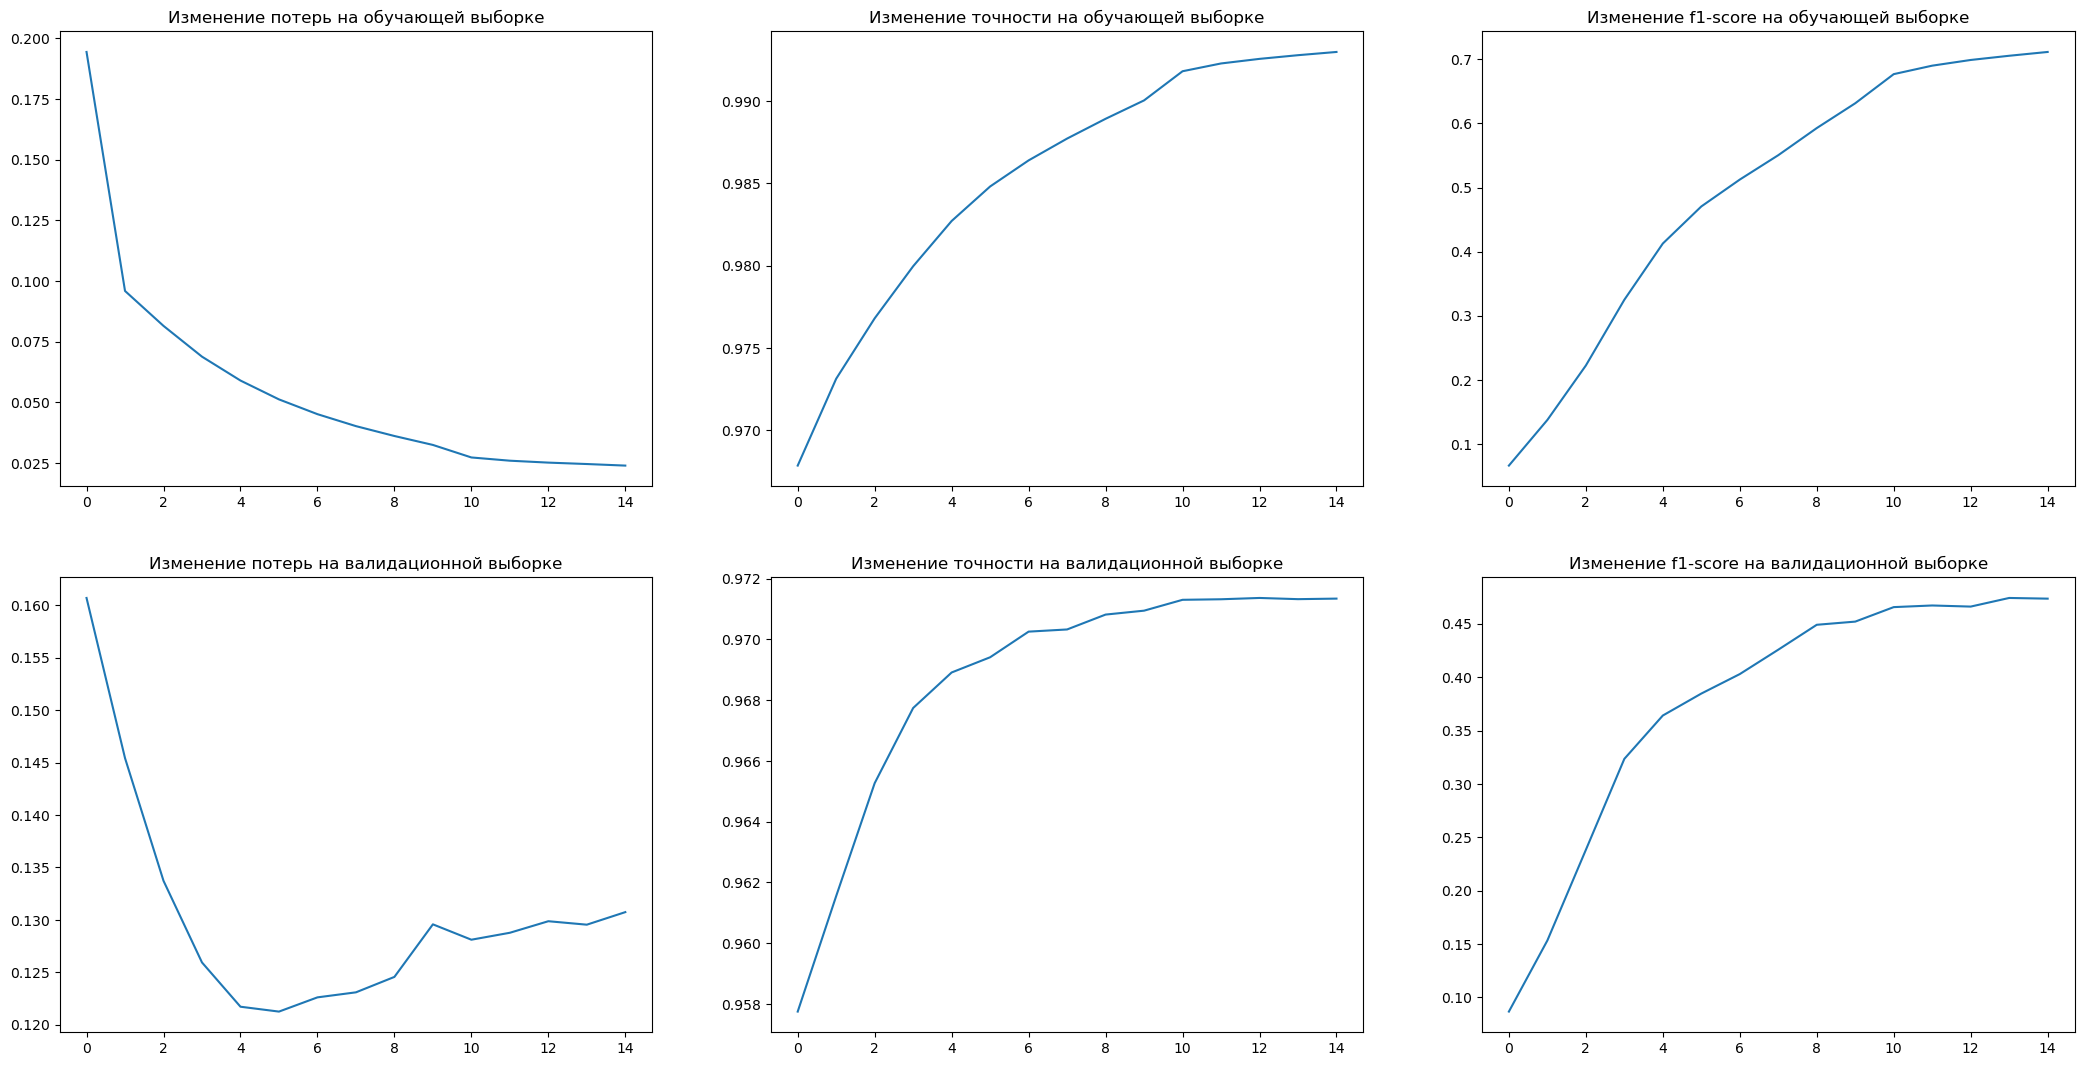

In [338]:
import matplotlib.pyplot as plt
graf(loss, acc)

In [290]:
torch.save(model.state_dict(),'cnn_lstm.pth')

In [224]:
def make_test(model,dataloader,dataset):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    acc_list = []
    model.eval()
    for inputs, labels in tqdm(dataloader):
        batch_size, n_words, n_classes = labels.shape
        labels = labels.reshape(-1, n_classes).to(device)
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        all_true_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())
    epoch_acc = accuracy_score(all_preds, all_true_labels)
    epoch_f1 = f1_score(all_preds, all_true_labels, average='macro')
    print('acc: {:.4f}, f1: {:.4f}'.format(epoch_acc, epoch_f1))
    acc_list.append(epoch_acc.tolist())
    return all_true_labels,all_preds

In [215]:
data_lst = list(set([item[:-4] for item in os.listdir(PATH4)]))
# некоторые файлы не парсятся
data_lst.remove('31339221025603182330049_24_part_1')
data_lst.remove('31339131024502051716072_24_part_1')
data_lst.remove('31339251033301001216016_20_part_2')
data_lst.remove('31339011021101006981035_9_part_1')
data_lst.remove('31339011021100987258005_5_part_2')
data_lst.remove('31339011061672000026002_4_part_2')
data_lst.remove('31339011026200597103018_8_part_1')
data_lst.remove('31339201027002952877006_14_part_2')
test_df = make_data(PATH4,data_lst)
test_df,max_len1 = make_tl(test_df)
test_df = make_pad(test_df)

100%|██████████| 536/536 [05:27<00:00,  1.64it/s]


(33084, 568)


In [296]:
dataset =  TokenDataset(test_df)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)
all_t,all_p = make_test(model,test_dataloader,dataset)

100%|██████████| 16542/16542 [02:43<00:00, 101.14it/s]


acc: 0.9910, f1: 0.3386


In [229]:
# убираем паддинги 
def remove_pad(df):
    """
    убираем паддинги
    """
    data = {'sentence': df['sentence'], 'real_cat': np.array_split(all_t, len(df['sentence'])), 'pred_cat':np.array_split(all_p, len(df['sentence']))}
    df_test_see = pd.DataFrame(data)
    for ind in df_test_see.index:
        sent = df_test_see['sentence'][ind]
        try:
            len_pad = sent.index(next(filter(lambda x: x!=0, sent)))
        except StopIteration:
            pass
        sent = sent[len_pad:]
        sent = vocab.lookup_tokens(sent)
        df_test_see.at[ind, 'sentence'] = sent 
        sent = df_test_see['real_cat'][ind]
        sent = sent[len_pad:]
        sent = vocab_lables.lookup_tokens(sent)
        df_test_see.at[ind, 'real_cat'] = sent 
        sent = df_test_see['pred_cat'][ind]
        sent = sent[len_pad:]
        sent = vocab_lables.lookup_tokens(sent)
        df_test_see.at[ind, 'pred_cat'] = sent 
    return df_test_see

In [230]:
def make_show(row,lbl):
    """
    function for vizualize models reusults on test data
    inputs:
    row - a sentence, 
    lbl - true markup or prediction markup
    return text and spans 
    """
    spans = []
    coords = 0
    c1 = 0
    c2 = 0
    tag = ''
    text = ''
    last = 0
    for i in range(len(row)):
        text += row[i]+' '
        if lbl[i] in TAG:
            if 'B-' in lbl[i]:
                c1 = coords
                c2 = coords + len(row[i])
                tag = lbl[i][2:].upper()
                coords+=1+len(row[i])
            elif 'I-' in lbl[i]:
                c2+=1+len(row[i])
                coords+=1+len(row[i])
        elif lbl[i] =='O':
            coords += len(row[i])+1
        if (c1,c2,tag) !=(0, 0, ''):
            if last == c1:
                spans = spans[:-1]
            spans.append((c1,c2,tag))
            last = c1
    return text, spans

In [297]:
df_test_see = remove_pad(test_df)

In [335]:
row_idx = 228



row = df_test_see['sentence'][row_idx]
true_lbl = df_test_see['real_cat'][row_idx]
pred_lbl = df_test_see['pred_cat'][row_idx]
text,spans1 = make_show(row,true_lbl)
_,spans2 = make_show(row,pred_lbl)
print('true:')
show_span_box_markup(text, spans1)
print('pred:')
show_span_box_markup(text, spans2)

true:


pred:
